## Set-up environment

First, we install 🤗 Transformers, Datasets and SentencePiece (the latter is used for tokenization).

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.1 MB/s eta 0:00:00


In [2]:
!pip install -q datasets sentencepiece
# !pip install -q replicate langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00


## Load image

In [ ]:
# from datasets import load_dataset

# dataset = load_dataset("hf-internal-testing/example-documents")
# dataset[2]

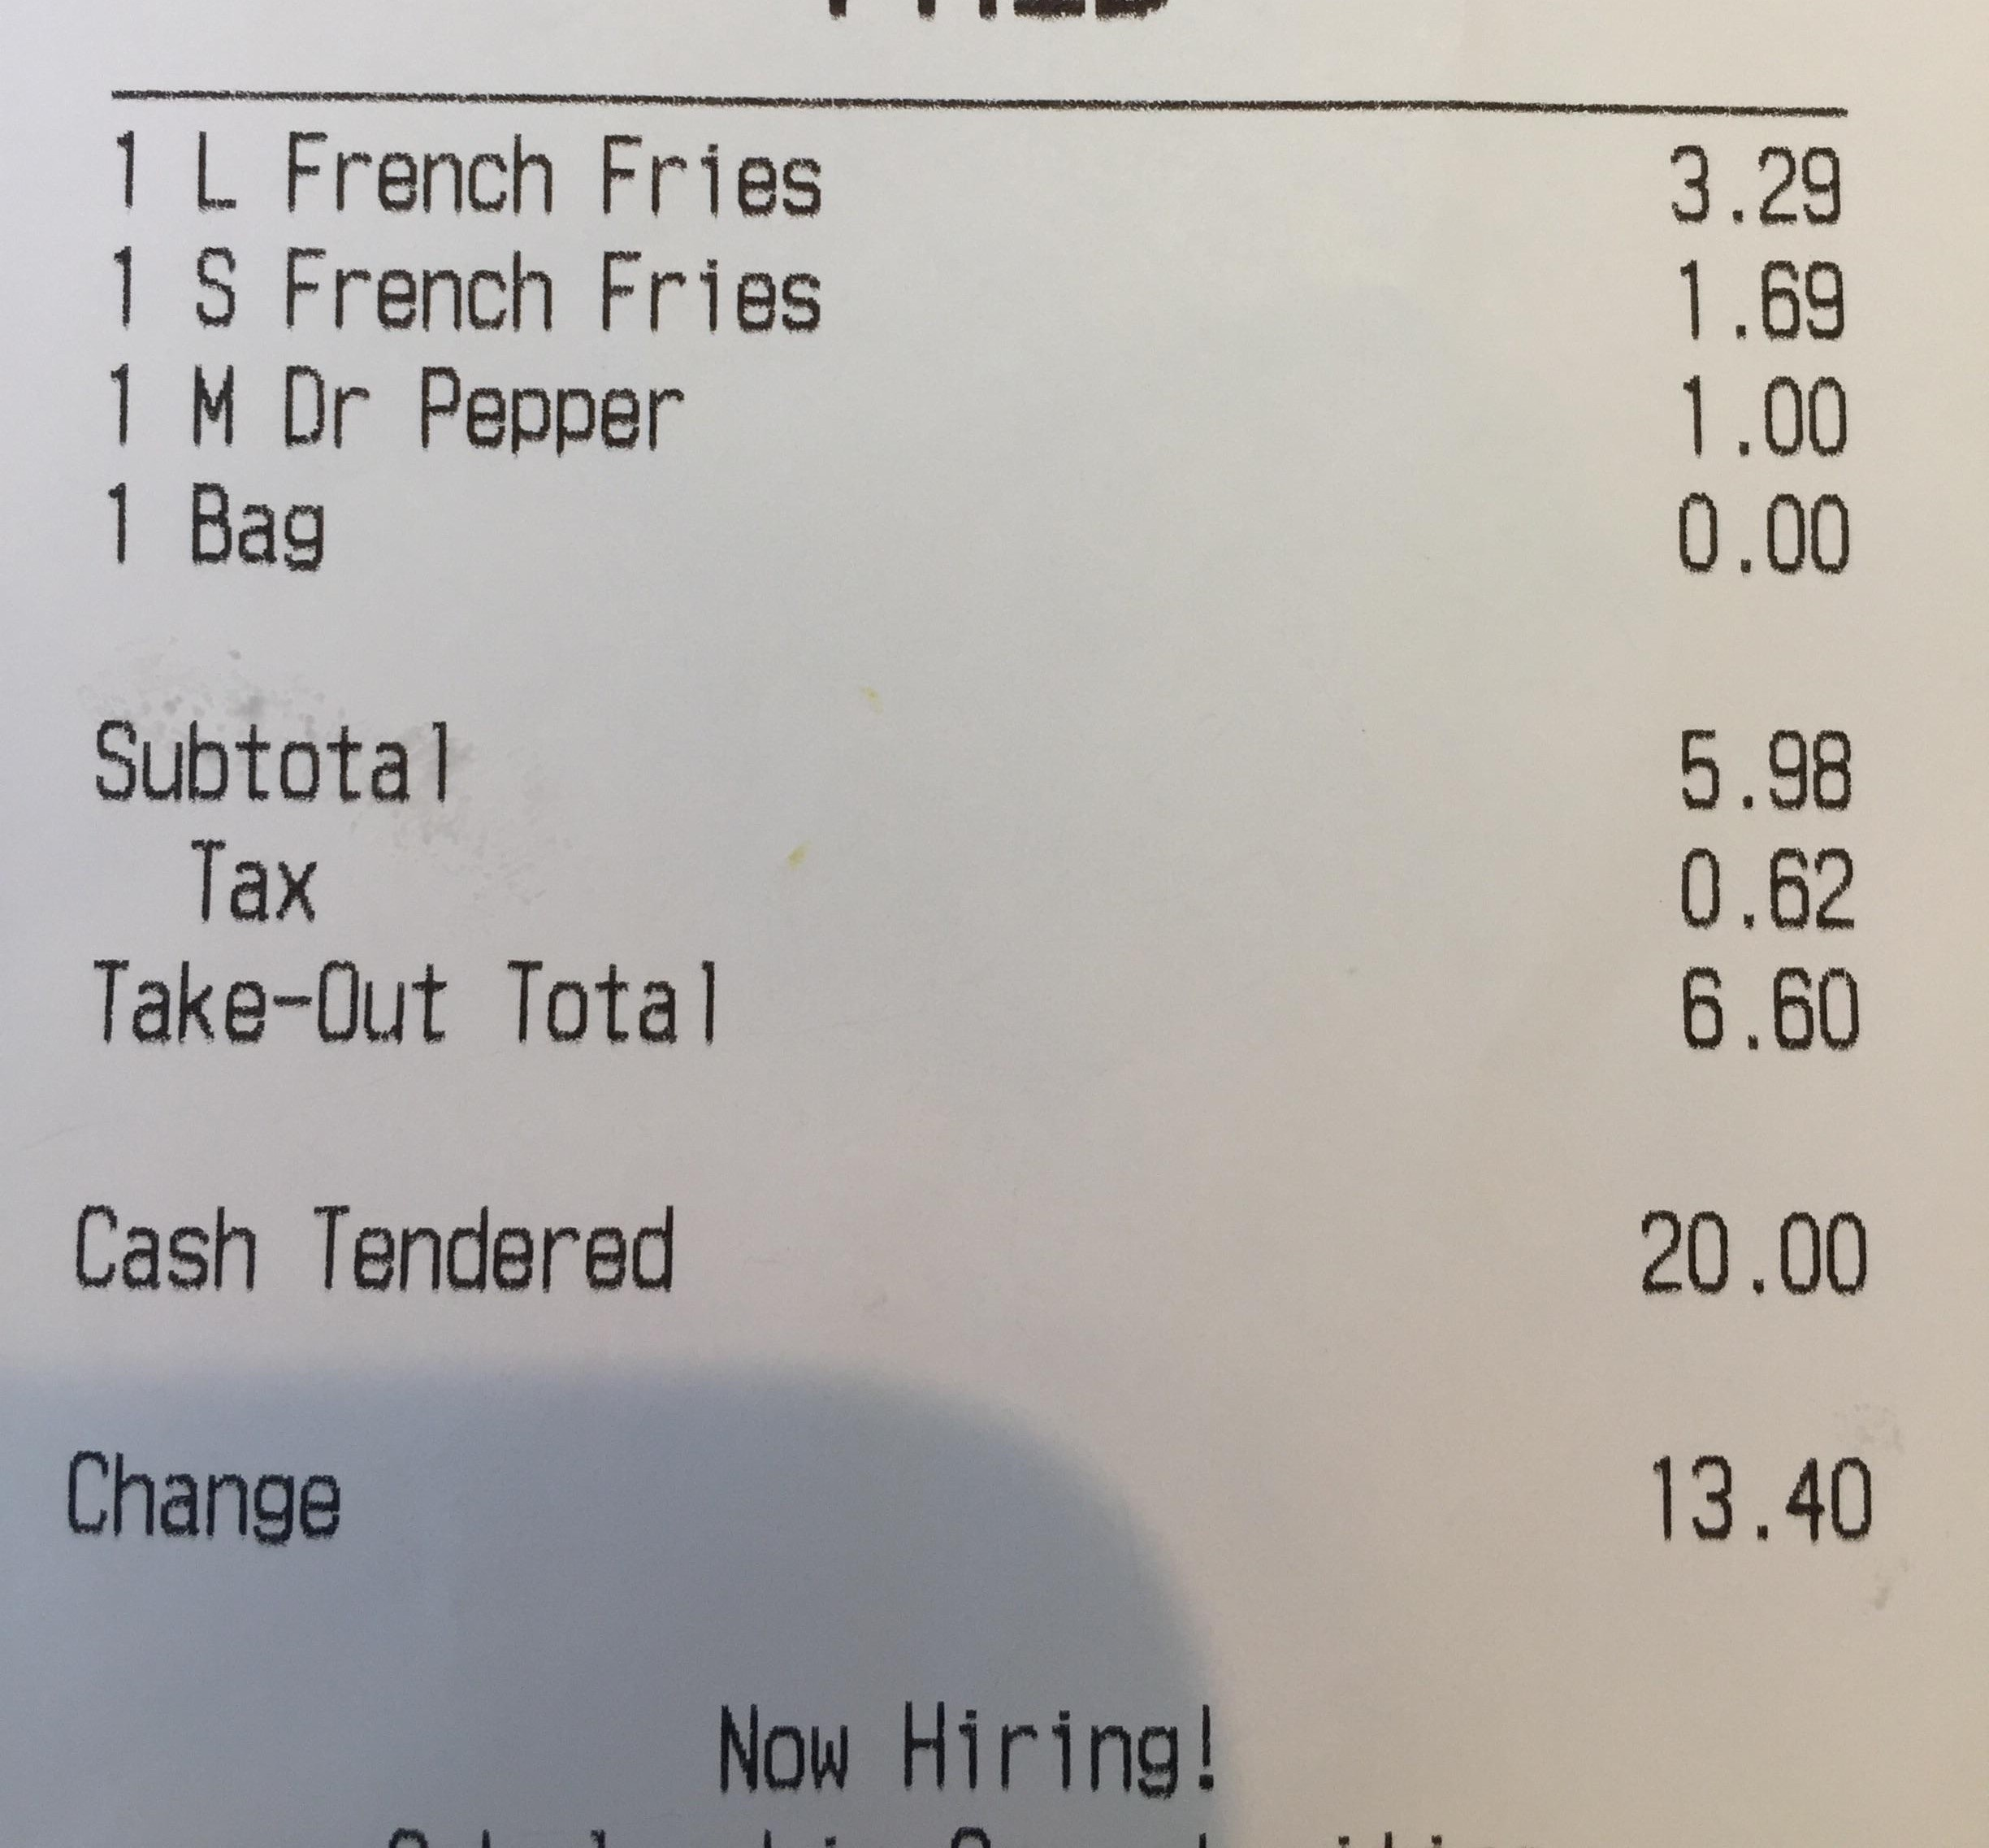

In [14]:
from PIL import Image


image = Image.open("/content/001.jpg")
image

# With image processing

In [20]:
import cv2
from PIL import Image
import numpy as np

# Membaca gambar menggunakan PIL
filename = "/content/001.jpg"
img = Image.open(filename)

# Konversi gambar ke citra skala abu-abu
gray_image = np.array(img.convert("L"))

# Edit bagian threshold
thresh, im_bw = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY)

# Konversi citra biner ke citra berwarna dengan latar belakang putih dan objek hitam
im_rgb = cv2.cvtColor(im_bw, cv2.COLOR_GRAY2RGB)

# Menyimpan gambar hasil olahan (optional)
cv2.imwrite("/content/binary.jpg", im_rgb)

# Sekarang Anda memiliki gambar dengan 3 dimensi (tinggi x lebar x kanal warna)


True

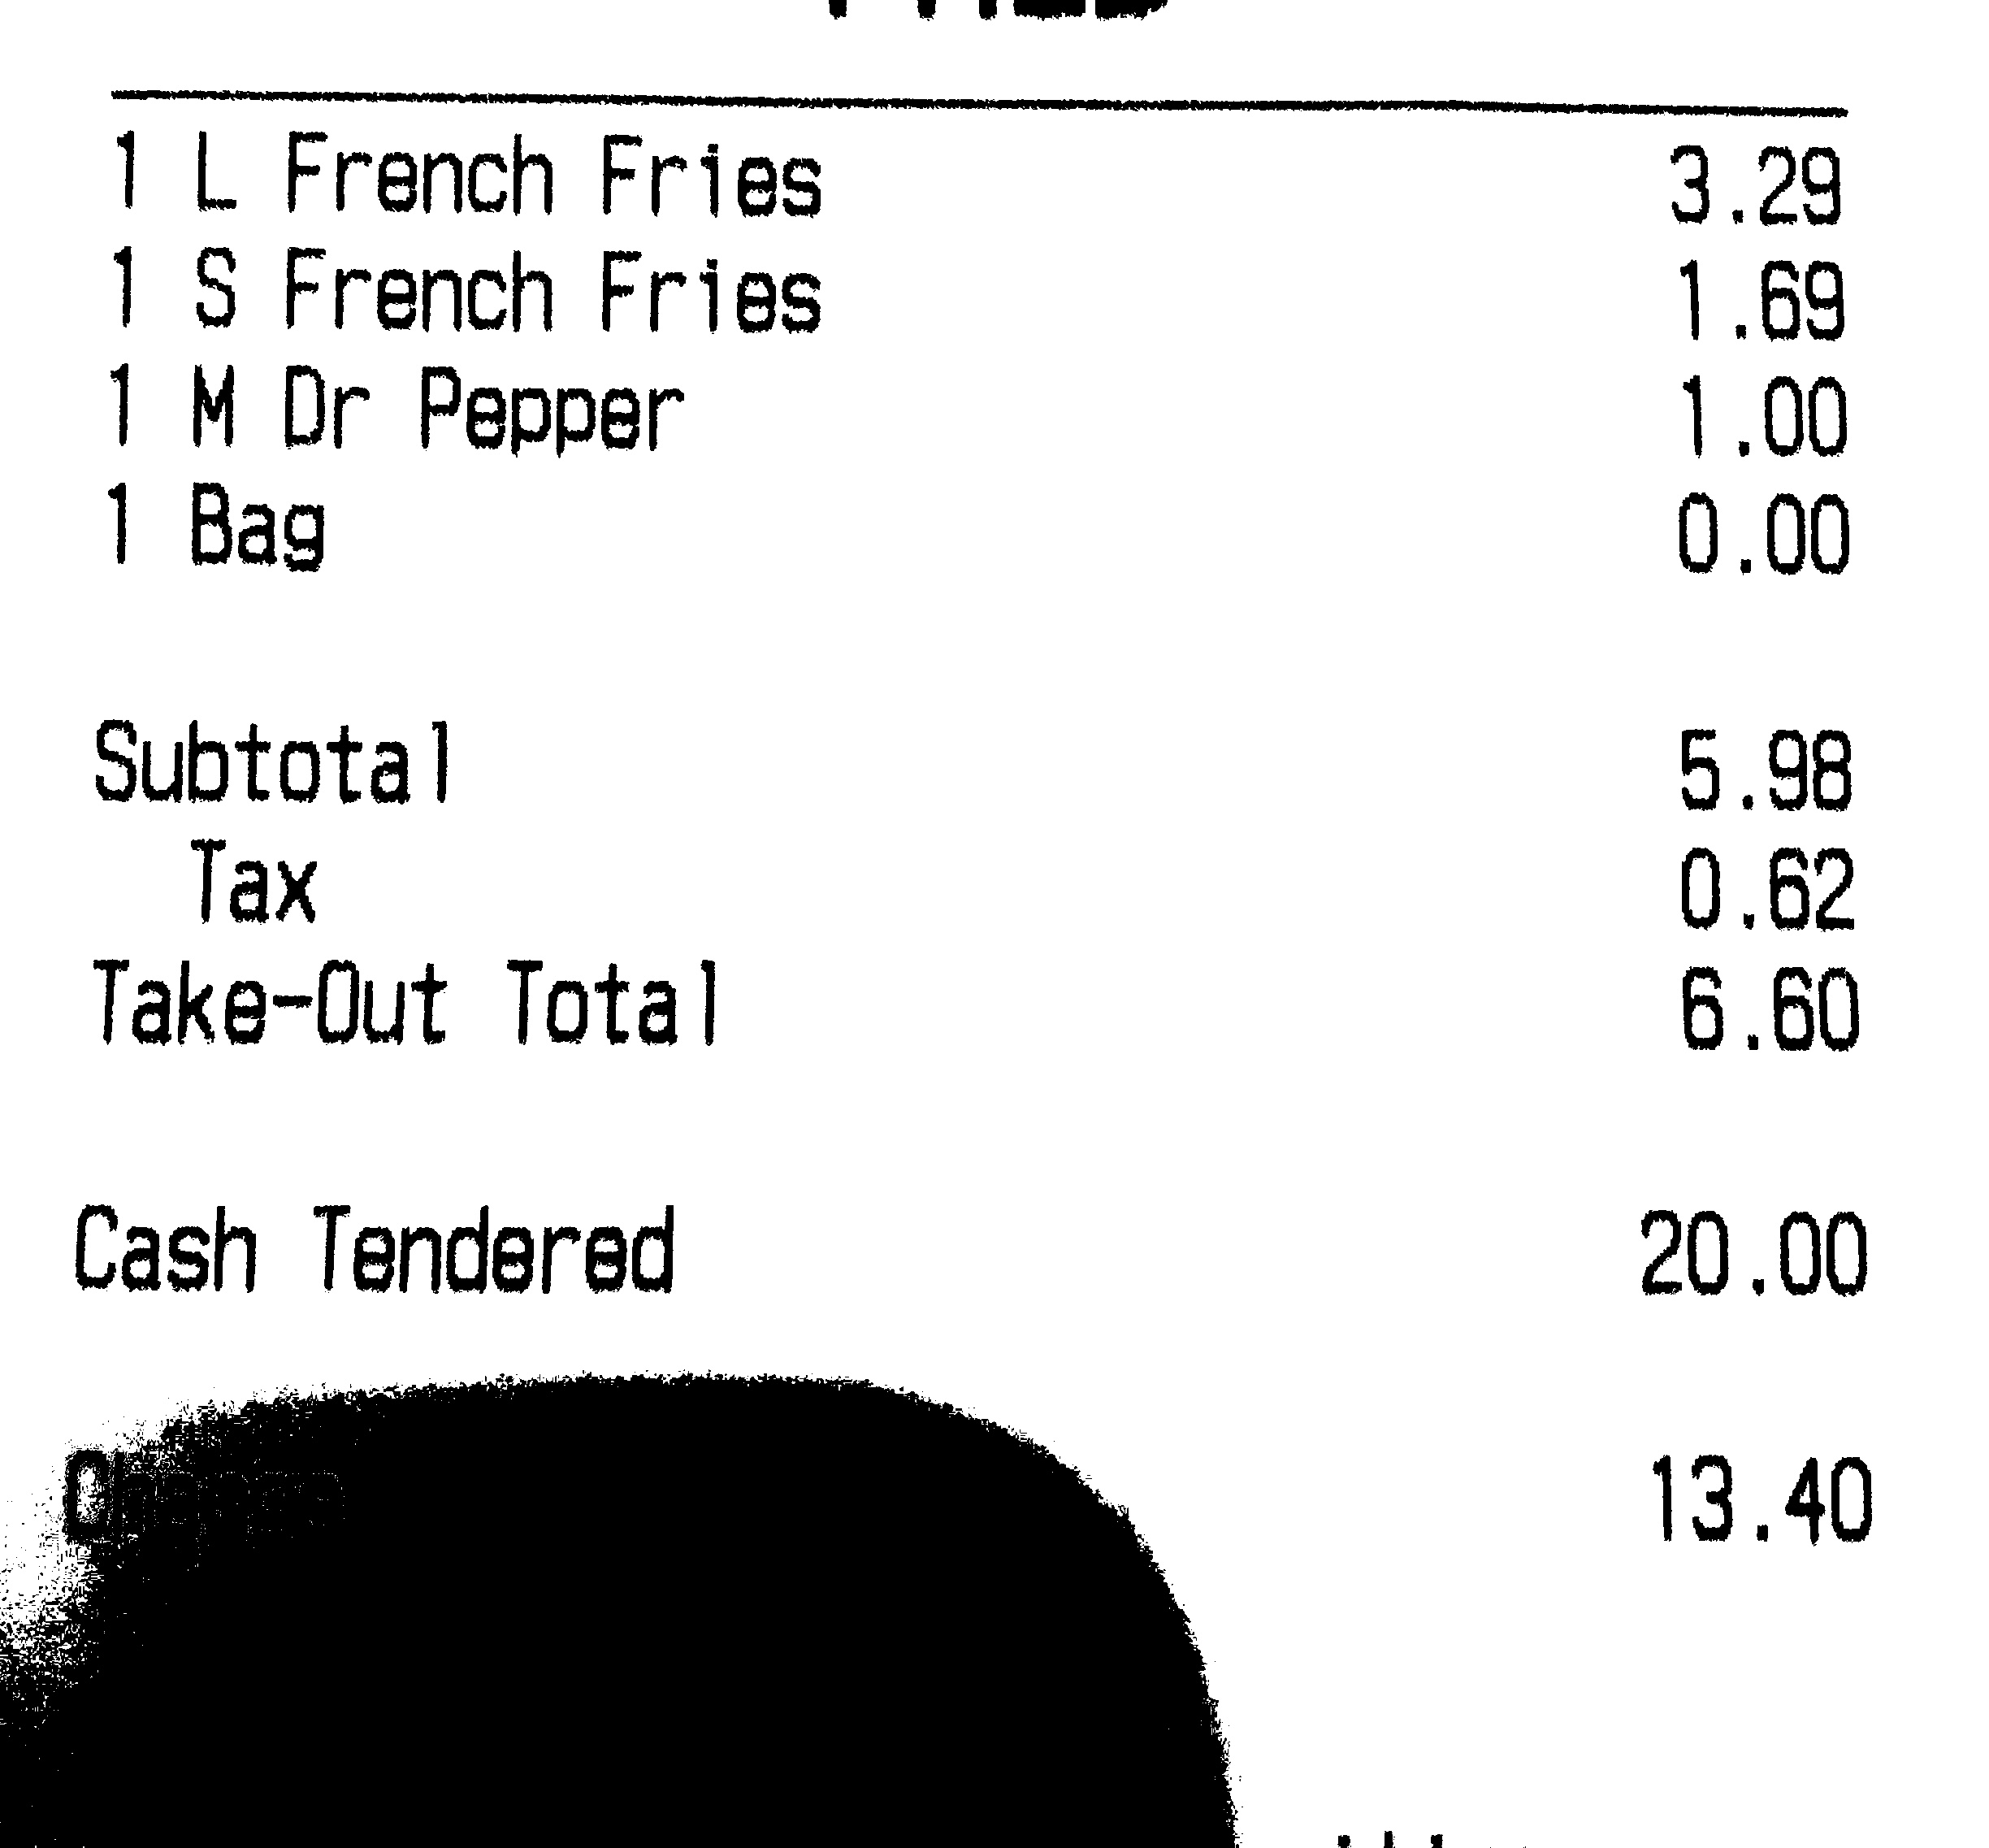

In [18]:
enchanced_image = Image.open("/content/binary.jpg")
enchanced_image

## Load model and processor

In [6]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("fahmiaziz/finetune-donut-cord-v2.5")
model = VisionEncoderDecoderModel.from_pretrained("fahmiaziz/finetune-donut-cord-v2.5")

Loading the tokenizer from the `special_tokens_map.json` and the `added_tokens.json` will be removed in `transformers 5`,  it is kept for forward compatibility, but it is recommended to update your `tokenizer_config.json` by uploading it again. You will see the new `added_tokens_decoder` attribute that will store the relevant information.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Prepare using processor

We prepare the image for the model using `DonutProcessor`.

In [21]:
image.size

(2448, 2274)

In [22]:
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 1280, 960])


## Generate

Finally, we let the model autoregressively generate the structured data.

In [23]:
import torch

task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


In [24]:
import re

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token

In [25]:
sequence

'<s_menu><s_nm> L French Fries</s_nm><s_cnt> 1</s_cnt><s_price> 3.29</s_price><sep/><s_nm> S French Fries</s_nm><s_cnt> 1</s_cnt><s_price> 1.69</s_price><sep/><s_nm> M Dr Pepper</s_nm><s_cnt> 1</s_cnt><s_price> 1.00</s_price><sep/><s_nm> Bag</s_nm><s_cnt> 1</s_cnt><s_price> 0.00</s_price></s_menu><s_sub_total><s_subtotal_price> 5.98</s_subtotal_price><s_tax_price> 0.62</s_tax_price></s_sub_total><s_total><s_total_price> 6.60</s_total_price><s_cashprice> 20.00</s_cashprice><s_changeprice> 13.40</s_changeprice></s_total>'

## Convert to JSON

We can convert the generated sequence to JSON if required:

In [26]:
processor_json = processor.token2json(sequence)

In [27]:
processor_json

{'menu': [{'nm': 'L French Fries', 'cnt': '1', 'price': '3.29'},
  {'nm': 'S French Fries', 'cnt': '1', 'price': '1.69'},
  {'nm': 'M Dr Pepper', 'cnt': '1', 'price': '1.00'},
  {'nm': 'Bag', 'cnt': '1', 'price': '0.00'}],
 'sub_total': {'subtotal_price': '5.98', 'tax_price': '0.62'},
 'total': {'total_price': '6.60',
  'cashprice': '20.00',
  'changeprice': '13.40'}}

## With image processing

In [28]:
pixel_values = processor(enchanced_image, return_tensors="pt").pixel_values

In [29]:
task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


In [30]:
sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()

processor.token2json(sequence)

{'menu': [{'nm': 'L French Fries', 'cnt': '1', 'price': '3.29'},
  {'nm': 'S French Fries', 'cnt': '1', 'price': '1.69'},
  {'nm': 'M Dr Pepper', 'cnt': '1', 'price': '1.00'},
  {'nm': 'Bag', 'cnt': '1', 'price': '0.00'}],
 'sub_total': {'subtotal_price': '5.98', 'tax_price': '0.62'},
 'total': {'total_price': '6.60',
  'cashprice': '20.00',
  'changeprice': '13.40'}}

# Conclusion
- Only for receipt PHOTO, still not supported for Scan
- There is still a mistake that the store name, address, date etc. should be included in the menu (Users must input photos in the menu section and total as in the picture) because the CORD dataset only has grounth_truth in the form of a menu list, sub total, tax and total so the model can only extract it.
- No need for image processing (temporarily)

on the next occasion I will create my own dataset with some additions such as scans and add company name, address, date/time, for the resources there are all just need to execute and I will also share the tools.